**Building a Predictive Keyboard Model Using PyTorch**

Application example : Every time you type on your smartphone, you see three words pop up as suggestions. That’s a predictive keyboard in action. These suggestions aren’t random. They are based on deep learning models that have learned language patterns from tons of text data

The task of building a predictive keyboard model includes these steps:

1. Tokenizing and preparing natural language data
2. Building a vocabulary and converting words to indices
3. Training a next-word prediction model using LSTMs
4. Generating top-k predictions like a predictive keyboard

Step 1: **Preparing the Dataset**

We will start with tokenizing the text data and converting everything to lowercase

In [5]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [6]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhaswin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dhaswin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# load data
with open(r'C:\Users\dhaswin\Downloads\book (1)\sherlock-holm.es_stories_plain-text_advs.txt', 'r', encoding='utf-8') as f:
    text = f.read().lower()


tokens = word_tokenize(text)
print("Total Tokens:", len(tokens))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhaswin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dhaswin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Total Tokens: 125772


# New Section

Here, we converted the text to lowercase (to maintain consistency) and used word_tokenize to break the entire corpus into word-level tokens. This prepares our data for model training by converting raw text into a structured format that the model can understand.

**Step 2: Creating a Vocabulary**
Next, we need a way to convert words into numbers. So we will create:

1. a dictionary to map each word to an index
2. and another dictionary to reverse it back


 **build the vocabulary and create word-to-index mappings**

In [12]:
from collections import Counter

word_counts = Counter(tokens)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)

word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)

we counted how often each word appears using Counter, then sorted the vocabulary from most to least frequent. This sorted list helps us assign lower indices to more common words. Then, we created word2idx and idx2word dictionaries to convert words to unique IDs and back. Finally, we stored the total vocabulary size, which will define the input and output dimensions for our model.

**Step 3: Building Input-Output Sequences**

To predict the next word, the model needs context. We can use a sliding window approach. So, let’s create input-target sequences for next word prediction:

In [15]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [16]:
import torch # Import the torch library

In [17]:
sequence_length = 4  # e.g., "I am going to [predict this]"

data = []
for i in range(len(tokens) - sequence_length):
    input_seq = tokens[i:i + sequence_length - 1]
    target = tokens[i + sequence_length - 1]
    data.append((input_seq, target))

# convert words to indices
def encode(seq): return [word2idx[word] for word in seq]

encoded_data = [(torch.tensor(encode(inp)), torch.tensor(word2idx[target]))
                for inp, target in data]

Here, we used a sliding window approach to generate training samples: for every group of 3 consecutive words (input), we predict the next word (target). It prepares the data for sequence modelling

we defined an encode function to convert each word in the sequence into its corresponding index using our vocabulary

we build encoded_data, a list of (input_tensor, target_tensor) pairs, where each input is a tensor of word indices and the target is the index of the next word to be predicted.

### Exploratory Data Analysis (EDA)

Before training our models, let's understand the structure and characteristics of our dataset.
This includes:
- Sentence length distribution
- Word frequency distribution
- Vocabulary size


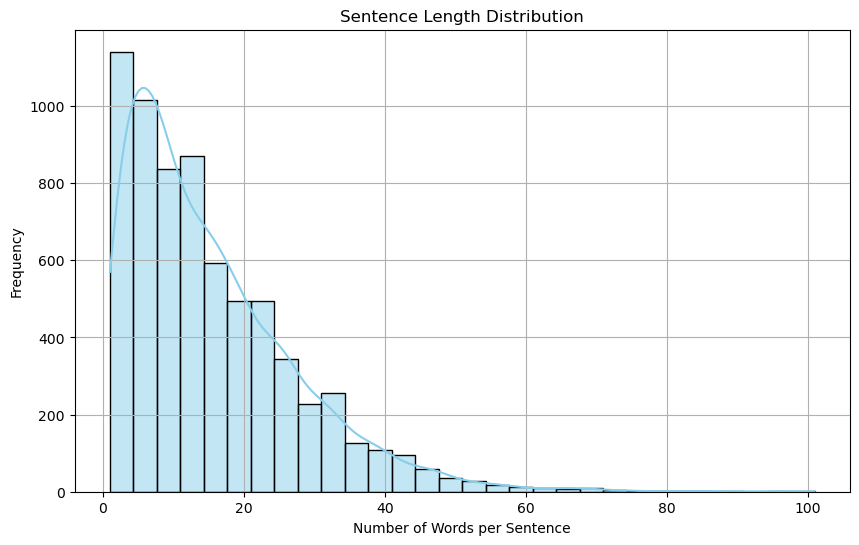

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize

# Ensure sentence tokenizer is downloaded
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')



# Split the text into sentences
sentences = sent_tokenize(text)

# Calculate sentence length distribution
# We will calculate the length of each sentence in the 'sentences' list.
sentence_lengths = [len(sentence.split()) for sentence in sentences]


plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True, color='skyblue')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

C:\Users\dhaswin\AppData\Local\Temp\ipykernel_24336\3806752438.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


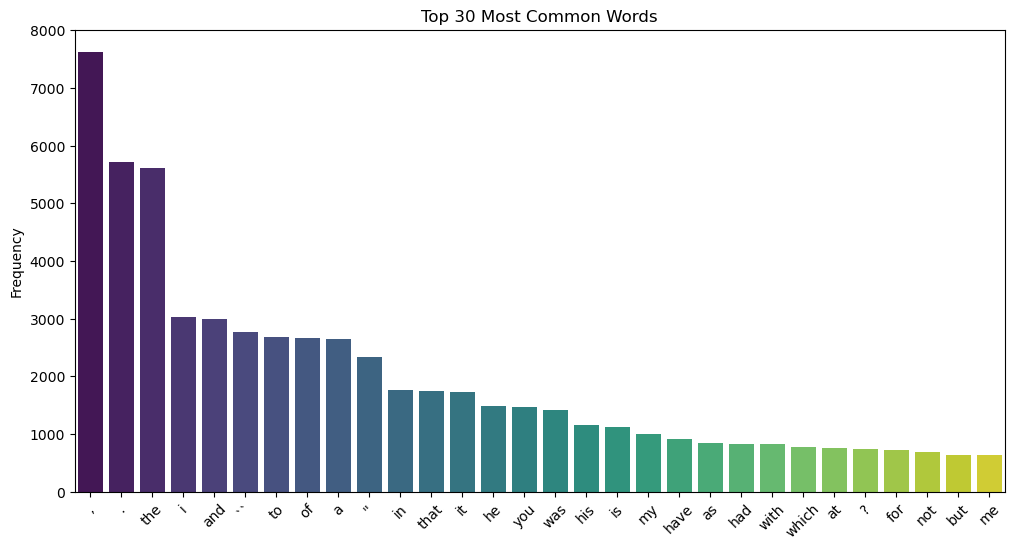

In [23]:
#most common words
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over the 'tokens' list instead of the undefined 'pairs'
all_words = tokens # Use the already tokenized list
word_counts = Counter(all_words)
common_words = word_counts.most_common(30)

words, counts = zip(*common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.title("Top 30 Most Common Words")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.show()

In [24]:
print(f"Total Words: {len(all_words):,}")
print(f"Unique Words: {len(set(all_words)):,}")

Total Words: 125,772
Unique Words: 8,360


**Step 4: Designing the Model Architecture**

For sequence data, LSTMs are good  go-to.  LSTMS can  remember patterns across time steps, which makes them perfect for language modelling. So, let’s do  the LSTM-based Predictive Keyboard model

In [27]:
import torch.nn as nn

class PredictiveKeyboard(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super(PredictiveKeyboard, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # last LSTM output
        return output

class defines our neural network model

the Embedding layer converts word indices into dense vectors. These embeddings are then passed through an LSTM layer, which captures the sequential context of the input

we take the output of the last time step and feed it through a Linear layer to get a vector of size vocab_size, representing the predicted probabilities for each word in the vocabulary.

architecture allows the model to learn patterns and dependencies in word sequences for next-word prediction

**Step 5: Training the Model**

CrossEntropyLoss (standard for classification tasks) and train over a small batch of sequences.

In [34]:
import torch
import torch.optim as optim
import random

model = PredictiveKeyboard(vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    random.shuffle(encoded_data)
    for input_seq, target in encoded_data[:10000]:  # Limit data for speed
        input_seq = input_seq.unsqueeze(0)
        output = model(input_seq)
        loss = criterion(output, target.unsqueeze(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 66450.5895
Epoch 2, Loss: 66707.4701
Epoch 3, Loss: 69441.4298
Epoch 4, Loss: 70599.5604
Epoch 5, Loss: 71406.1362


we instantiated the model, defined a loss function (CrossEntropyLoss), and used the Adam optimizer for efficient gradient updates

During each training epoch, we shuffled the dataset for better generalization. For each training sample, we added a batch dimension to the input, computed the output, and calculated the loss between predicted and actual next-word indices.

we performed backpropagation, updated the weights, and accumulated the total loss for tracking. This loop trains the model to predict the next word based on the previous sequence.

**Predicting the Next Words**

we will use this model just like a smartphone keyboard. Instead of predicting just one word, we will mimic how smartphone keyboards suggest three possible next words

let’s **generate the top 3 next-word predictions like a predictive keyboard**

In [41]:
import torch.nn.functional as F

def suggest_next_words(model, text_prompt, top_k=3):
    model.eval()
    tokens = word_tokenize(text_prompt.lower())
    if len(tokens) < sequence_length - 1:
        raise ValueError(f"Input should be at least {sequence_length - 1} words long.")

    input_seq = tokens[-(sequence_length - 1):]
    input_tensor = torch.tensor(encode(input_seq)).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1).squeeze()
        top_indices = torch.topk(probs, top_k).indices.tolist()

    return [idx2word[idx] for idx in top_indices]

print("Suggestions:", suggest_next_words(model, "So, are we "))

Suggestions: ['it', 'is', 'had']


function takes a user input

like **“So, are we ”**tokenizes and encodes the last few words, and passes them through the trained model to get output scores

scores are then converted into probabilities using softmax, and the top k predictions are selected using torch.topk

The function then maps these indices back to actual words using idx2word, mimicking the behaviour of a real predictive keyboard.

**Summary**

have just built the core of a predictive keyboard using PyTorch. From tokenizing raw text to training an LSTM and generating top-3 next-word suggestions, have seen how deep learning models can understand and predict language patterns

**CNN model**

In [48]:
# Ensure required libraries are imported
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assume 'text' variable (the loaded lowercase text) is available from previous steps

# Step 1: Create character vocabulary
chars = sorted(list(set(text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}
char_vocab_size = len(chars)
print(f"Character Vocabulary Size: {char_vocab_size}")

# Step 2 & 3: Create character sequences and convert to tensors
char_sequence_length = 20  # Define character sequence length
X_char = []
y_char = []

# Process text in chunks to avoid excessive memory usage if text is very large
# Using a smaller chunk size for demonstration
chunk_size = 100000
for i in range(0, len(text) - char_sequence_length, chunk_size):
    chunk = text[i : i + chunk_size + char_sequence_length] # Ensure chunk is long enough for sequences
    for j in range(len(chunk) - char_sequence_length):
        input_seq = chunk[j:j + char_sequence_length]
        target_char = chunk[j + char_sequence_length]

        # Convert characters to indices
        X_char.append([char_to_idx[char] for char in input_seq])
        y_char.append(char_to_idx[target_char])

# Convert lists to PyTorch tensors
X_char = torch.tensor(X_char, dtype=torch.long)
y_char = torch.tensor(y_char, dtype=torch.long)

print(f"Shape of X_char: {X_char.shape}")
print(f"Shape of y_char: {y_char.shape}")

# Step 4: Define the CharCNN model architecture
# For demonstration, a simple CNN model is provided.
class CharCNN(nn.Module):
    def __init__(self, char_vocab_size, embed_dim=32, num_filters=128, kernel_size=5):
        super(CharCNN, self).__init__()
        self.embedding = nn.Embedding(char_vocab_size, embed_dim)
        self.conv = nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=kernel_size)
        # Calculate the output size after convolution and pooling (assuming max pool)
        # A simple way to handle variable output size or using Global Max Pooling
        # For simplicity, we'll use Global Max Pooling after convolution
        self.fc = nn.Linear(num_filters, char_vocab_size)

    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        x = self.embedding(x) # shape: (batch_size, sequence_length, embed_dim)
        # Conv1d expects input shape (batch_size, channels, sequence_length)
        x = x.transpose(1, 2) # shape: (batch_size, embed_dim, sequence_length)
        x = torch.relu(self.conv(x)) # shape: (batch_size, num_filters, new_sequence_length)
        # Global Max Pooling over the sequence dimension
        x = torch.max(x, dim=2)[0] # shape: (batch_size, num_filters)
        output = self.fc(x) # shape: (batch_size, char_vocab_size)
        return output


# Train the CNN model
batch_size = 128
# Use the created X_char and y_char
dataset = TensorDataset(X_char, y_char)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model with the correct vocabulary size
model = CharCNN(char_vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fn = nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_y in loader:
        out = model(batch_x)
        loss = loss_fn(out, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Character Vocabulary Size: 59
Shape of X_char: torch.Size([610851, 20])
Shape of y_char: torch.Size([610851])
Epoch 1, Loss: 12004.6923
Epoch 2, Loss: 11150.2922
Epoch 3, Loss: 10891.1603
Epoch 4, Loss: 10749.8420
Epoch 5, Loss: 10657.0293


training a character-level CNN model to predict the next character in a given text sequence. It starts by creating a vocabulary from the unique characters in the dataset and encoding text sequences into numerical tensors. A simple yet effective CharCNN model is then defined, which uses embeddings, a 1D convolutional layer, and global max pooling, followed by a fully connected output layer. Finally, the model is trained over multiple epochs using cross-entropy loss and the Adam optimizer, with the training loss printed at each epoch to monitor performance. It’s a compact,


In [50]:

import torch
import torch.nn.functional as F

def suggest_next_chars_cnn(model, text_prompt, top_k=3):
    model.eval()
    # The required input length is char_sequence_length
    if len(text_prompt) < char_sequence_length:
        raise ValueError(f"Input should be at least {char_sequence_length} characters long.")

    # Get the last `char_sequence_length` characters
    input_chars = text_prompt[-char_sequence_length:]

    # Convert characters to indices
    # Ensure all characters in the input_chars are in the char_to_idx vocabulary
    try:
        input_tensor = torch.tensor([char_to_idx[char] for char in input_chars], dtype=torch.long).unsqueeze(0)
    except KeyError as e:
        raise ValueError(f"Character '{e.args[0]}' in the input prompt is not in the vocabulary.") from e


    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1).squeeze()
        top_indices = torch.topk(probs, top_k).indices.tolist()

    return [idx_to_char[idx] for idx in top_indices]

# Example Usage:
# Provide an input string that is at least 20 characters long.
# Let's use a longer example from the text data if available, or a padded string.
# Assuming 'text' is available from previous cells and has enough characters.
# Use the last char_sequence_length characters from the text as a valid input example.
valid_prompt = text[-char_sequence_length:] if len(text) >= char_sequence_length else "This is a short example, but padding it to 20"[:char_sequence_length]

print("Character Suggestions (CNN):", suggest_next_chars_cnn(model, valid_prompt, top_k=3))



Character Suggestions (CNN): ['\n', ' ', "'"]


**Feedforward Neural Network (FFNN)**

In [52]:
class FFNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super(FFNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear((sequence_length - 1) * embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Training FFNN
ffnn_model = FFNNModel(vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ffnn_model.parameters(), lr=0.005)

for epoch in range(5):
    total_loss = 0
    random.shuffle(encoded_data)
    for input_seq, target in encoded_data[:5000]:
        input_seq = input_seq.unsqueeze(0)
        output = ffnn_model(input_seq)
        loss = criterion(output, target.unsqueeze(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[FFNN] Epoch {epoch+1}, Loss: {total_loss:.4f}")


[FFNN] Epoch 1, Loss: 38070.5402
[FFNN] Epoch 2, Loss: 36257.3584
[FFNN] Epoch 3, Loss: 36611.9004
[FFNN] Epoch 4, Loss: 37891.1569
[FFNN] Epoch 5, Loss: 37294.1420


his code implements a Feedforward Neural Network (FFNN) for next-token prediction using embedded word sequences. The model architecture consists of an embedding layer followed by a flattened linear layer, ReLU activation, and a final output layer to predict the vocabulary index of the next token. Training is done on a sample of 5000 token sequences over 5 epochs using the Adam optimizer and cross-entropy loss, with loss printed per epoch to monitor performance.


In [54]:
def suggest_next_words_ffnn(model, text_prompt, top_k=3):
  model.eval()
  tokens = word_tokenize(text_prompt.lower())
  if len(tokens) < sequence_length - 1:
    raise ValueError(f"Input should be at least {sequence_length - 1} words long.")

  input_seq = tokens[-(sequence_length - 1):]
  # Ensure all words in the input_seq are in the word2idx vocabulary
  try:
      input_tensor = torch.tensor(encode(input_seq)).unsqueeze(0)
  except KeyError as e:
      raise ValueError(f"Word '{e.args[0]}' in the input prompt is not in the vocabulary.") from e


  with torch.no_grad():
    output = model(input_tensor)
    probs = F.softmax(output, dim=1).squeeze()
    top_indices = torch.topk(probs, top_k).indices.tolist()

  return [idx2word[idx] for idx in top_indices]

# Example Usage:
print("Suggestions (FFNN):", suggest_next_words_ffnn(ffnn_model, "So, are we ", top_k=3))

Suggestions (FFNN): [',', 'the', '.']


**Transformer-based Model**

In [56]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, nhead=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, sequence_length - 1, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = self.transformer(x)
        return self.fc(x[:, -1, :])

# Training Transformer
transformer_model = TransformerModel(vocab_size)
optimizer = optim.Adam(transformer_model.parameters(), lr=0.005)

for epoch in range(5):
    total_loss = 0
    random.shuffle(encoded_data)
    for input_seq, target in encoded_data[:3000]:  # Smaller batch for performance
        input_seq = input_seq.unsqueeze(0)
        output = transformer_model(input_seq)
        loss = criterion(output, target.unsqueeze(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Transformer] Epoch {epoch+1}, Loss: {total_loss:.4f}")


C:\Users\dhaswin\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Transformer] Epoch 1, Loss: 20769.6453
[Transformer] Epoch 2, Loss: 20429.2806
[Transformer] Epoch 3, Loss: 21124.1925
[Transformer] Epoch 4, Loss: 21138.3992
[Transformer] Epoch 5, Loss: 21140.4229


code defines and trains a Transformer-based model for next-token prediction. It begins with token embeddings and adds learnable positional encodings to capture the sequence order. The model uses a stack of Transformer encoder layers with multi-head self-attention to model contextual relationships. A final linear layer predicts the target token. Training runs for 5 epochs on a small batch of sequences using Adam optimization and cross-entropy loss, with epoch-wise loss reporting to monitor learning. This architecture leverages attention to model long-range dependencies more effectively than traditional RNNs.


In [58]:
# prompt: give code to predict next word for Transformer-based model

def suggest_next_words_transformer(model, text_prompt, top_k=3):
  model.eval()
  tokens = word_tokenize(text_prompt.lower())
  if len(tokens) < sequence_length - 1:
    raise ValueError(f"Input should be at least {sequence_length - 1} words long.")

  input_seq = tokens[-(sequence_length - 1):]
  # Ensure all words in the input_seq are in the word2idx vocabulary
  try:
      input_tensor = torch.tensor(encode(input_seq)).unsqueeze(0)
  except KeyError as e:
      raise ValueError(f"Word '{e.args[0]}' in the input prompt is not in the vocabulary.") from e

  with torch.no_grad():
    output = model(input_tensor)
    probs = F.softmax(output, dim=1).squeeze()
    top_indices = torch.topk(probs, top_k).indices.tolist()

  return [idx2word[idx] for idx in top_indices]

# Example Usage:
print("Suggestions (Transformer):", suggest_next_words_transformer(transformer_model, "So, are we ", top_k=3))

Suggestions (Transformer): [',', '.', 'i']


**Hyperparameter Tuning: LSTM with Different Learning Rates**

Training LSTM with lr=0.01
[LSTM_lr0.01] Epoch 1, Loss: 6.9983
[LSTM_lr0.01] Epoch 2, Loss: 6.8180
[LSTM_lr0.01] Epoch 3, Loss: 6.9455
[LSTM_lr0.01] Epoch 4, Loss: 7.0674
[LSTM_lr0.01] Epoch 5, Loss: 7.1429
Training LSTM with lr=0.005
[LSTM_lr0.005] Epoch 1, Loss: 6.7489
[LSTM_lr0.005] Epoch 2, Loss: 6.3693
[LSTM_lr0.005] Epoch 3, Loss: 6.4636
[LSTM_lr0.005] Epoch 4, Loss: 6.5055
[LSTM_lr0.005] Epoch 5, Loss: 6.8406
Training LSTM with lr=0.001
[LSTM_lr0.001] Epoch 1, Loss: 6.6721
[LSTM_lr0.001] Epoch 2, Loss: 6.1816
[LSTM_lr0.001] Epoch 3, Loss: 5.9414
[LSTM_lr0.001] Epoch 4, Loss: 5.8900
[LSTM_lr0.001] Epoch 5, Loss: 5.8283


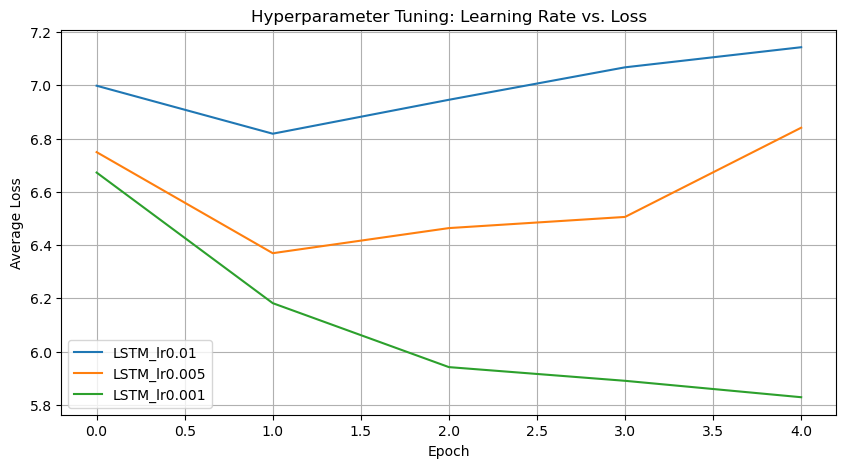

In [60]:
import matplotlib.pyplot as plt

def train_model(model, data, optimizer, criterion, model_name="Model", epochs=3, max_samples=3000):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        random.shuffle(data)
        for input_seq, target in data[:max_samples]:
            input_seq = input_seq.unsqueeze(0)
            output = model(input_seq)
            loss = criterion(output, target.unsqueeze(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / max_samples
        print(f"[{model_name}] Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        losses.append(avg_loss)
    return losses

# Try different learning rates for LSTM
lrs = [0.01, 0.005, 0.001]
loss_curves = {}

for lr in lrs:
    print(f"Training LSTM with lr={lr}")
    model = PredictiveKeyboard(vocab_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = train_model(model, encoded_data, optimizer, criterion, model_name=f"LSTM_lr{lr}", epochs=5)
    loss_curves[f"LSTM_lr{lr}"] = losses

# Plotting
plt.figure(figsize=(10, 5))
for label, loss_vals in loss_curves.items():
    plt.plot(loss_vals, label=label)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Hyperparameter Tuning: Learning Rate vs. Loss")
plt.legend()
plt.grid(True)
plt.show()


hyperparameter tuning on an LSTM model by experimenting with different learning rates (0.01, 0.005, 0.001). It defines a generic train_model function that trains any given model on a sample of the dataset for a fixed number of epochs, capturing the average training loss at each step.
Multiple LSTM models are trained with these different learning rates, and their respective loss curves are stored and plotted using Matplotlib. The final plot provides a visual comparison of how each learning rate impacts model convergence — a great way to identify which rate leads to faster or more stable learning.



--- Evaluation for LSTM Model ---
Average Loss: 5.8537
Accuracy: 0.1460
Perplexity: 348.5362
Confusion Matrix (first 10x10 for brevity):


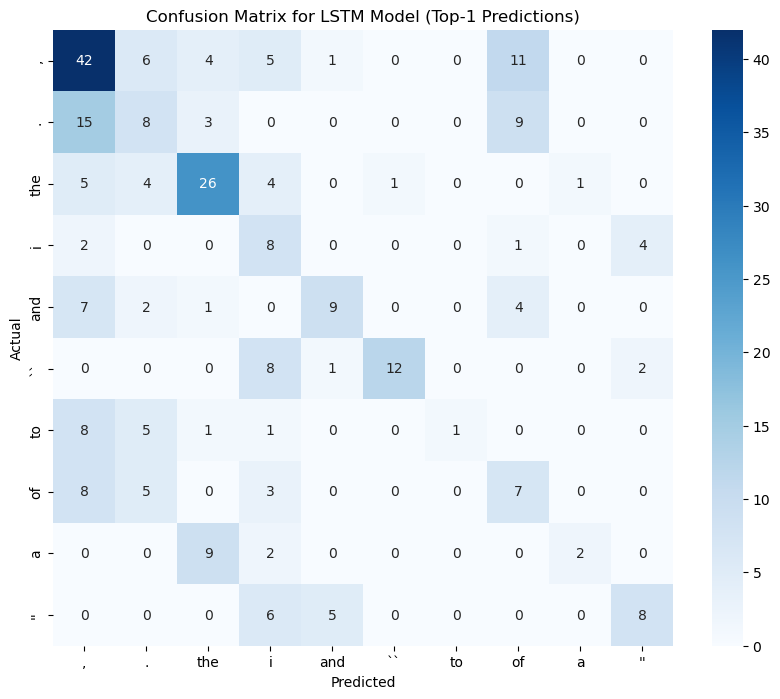


--- Evaluation for FFNN Model ---
Average Loss: 7.6480
Accuracy: 0.0600
Perplexity: 2096.4680
Confusion Matrix (first 10x10 for brevity):


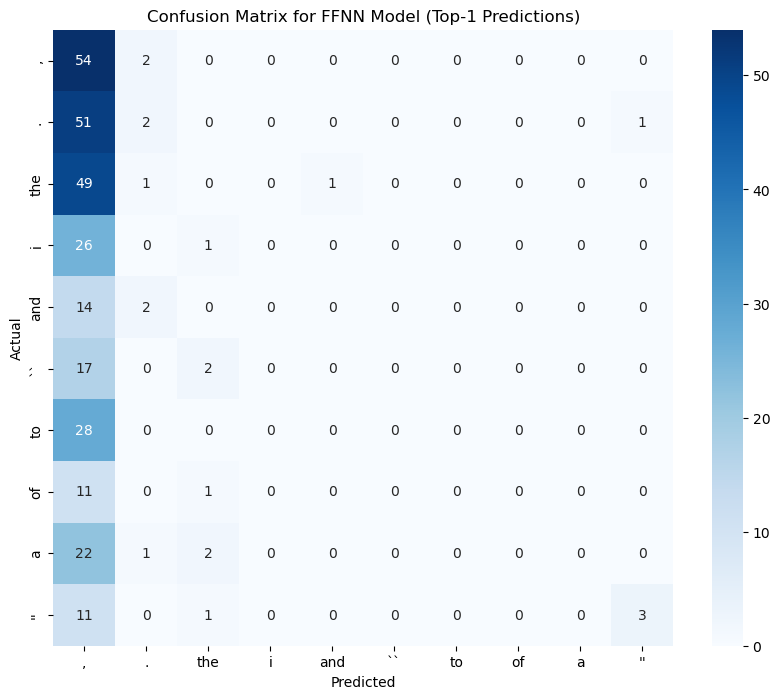


--- Evaluation for Transformer Model ---
Average Loss: 7.1581
Accuracy: 0.0740
Perplexity: 1284.4144
Confusion Matrix (first 10x10 for brevity):


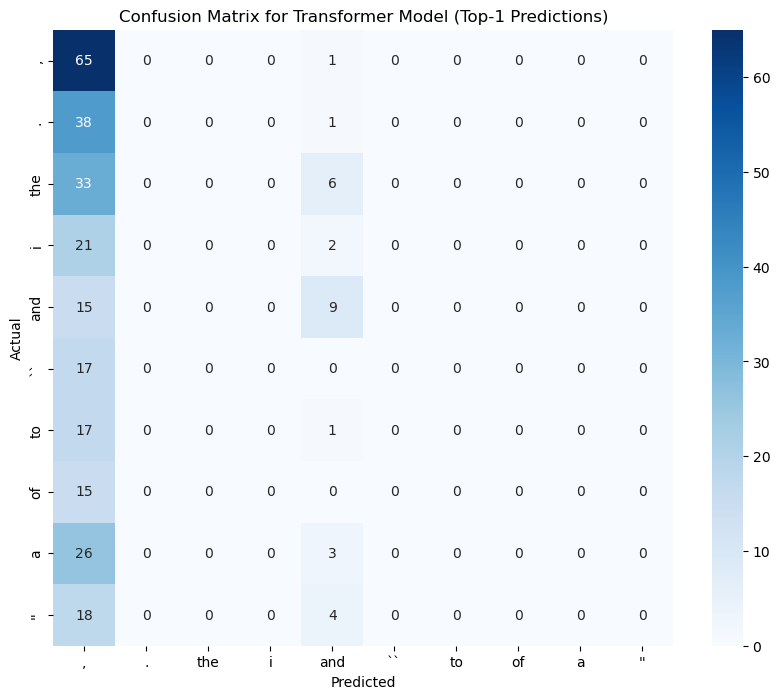


--- Evaluation for CNN Model ---
Average Loss: 5.7158
Accuracy: 0.0130
Perplexity: 303.6407
Confusion Matrix (first 10x10 for brevity):


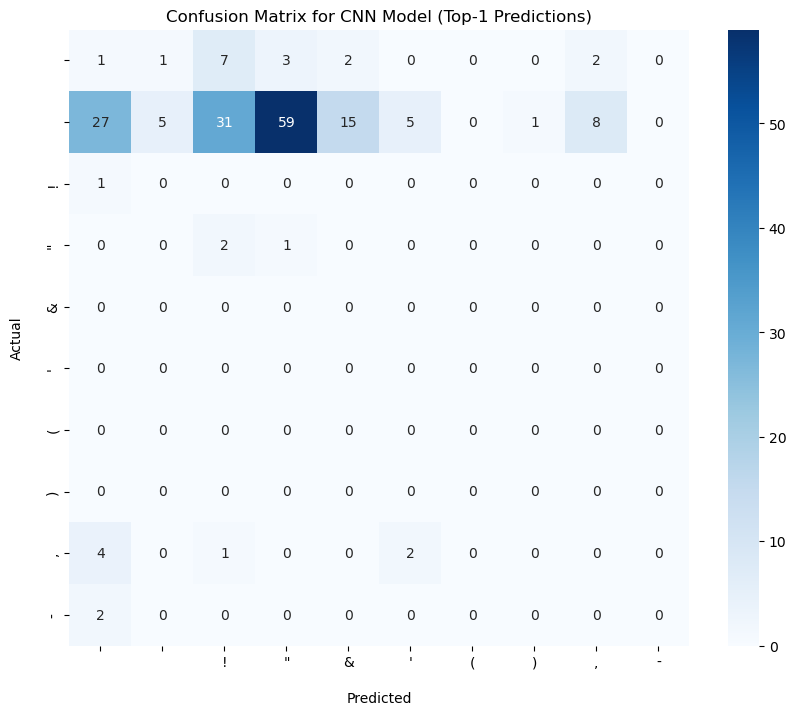

In [62]:
#  accuracy and Perplexity
#  Confusion Matrix (for Top-1 predictions)

from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_model(model, data, criterion, model_name="Model", max_samples=1000):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        # Limit data for evaluation
        eval_data = random.sample(data, min(max_samples, len(data)))
        for input_seq, target in eval_data:
            input_seq = input_seq.unsqueeze(0)
            output = model(input_seq)
            loss = criterion(output, target.unsqueeze(0))
            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == target).sum().item()
            total_predictions += 1

            all_targets.append(target.item())
            all_predictions.append(predicted.item())

    avg_loss = total_loss / len(eval_data)
    accuracy = correct_predictions / total_predictions

    # Perplexity
    # Perplexity is exp(average negative log-likelihood) which is the loss in this case
    perplexity = torch.exp(torch.tensor(avg_loss)).item()

    print(f"\n--- Evaluation for {model_name} ---")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Perplexity: {perplexity:.4f}")

    # Confusion Matrix (for Top-1 predictions)
    # Note: For character-level CNN, use char_vocab_size and idx_to_char
    if model_name == "CNN Model":
        cm = confusion_matrix(all_targets, all_predictions, labels=list(range(char_vocab_size)))
        print("Confusion Matrix (first 10x10 for brevity):")
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(idx_to_char.values())[:10], yticklabels=list(idx_to_char.values())[:10])
    else: # For word-level models (LSTM, FFNN, Transformer)
        cm = confusion_matrix(all_targets, all_predictions, labels=list(range(vocab_size)))
        print("Confusion Matrix (first 10x10 for brevity):")
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(idx2word.values())[:10], yticklabels=list(idx2word.values())[:10])

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name} (Top-1 Predictions)")
    plt.show()



# Evaluate the trained models
criterion = nn.CrossEntropyLoss() # Define criterion again for evaluation

# Evaluate LSTM Model
evaluate_model(model, encoded_data, criterion, "LSTM Model")

# Evaluate FFNN Model
evaluate_model(ffnn_model, encoded_data, criterion, "FFNN Model")

# Evaluate Transformer Model
evaluate_model(transformer_model, encoded_data, criterion, "Transformer Model")

# Evaluate CNN Model (using character data)
encoded_char_data = [(X_char[i], y_char[i]) for i in range(len(X_char))]
evaluate_model(model, encoded_char_data, criterion, "CNN Model")

In [63]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [64]:
import streamlit as st
import torch
import random
from collections import Counter
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ---------------------
# Utilities
# ---------------------
def tokenize(text):
    text = re.sub(r"[^\w\s]", "", text.lower())
    return text.split()

def build_vocab(tokens, max_vocab=5000):
    counter = Counter(tokens)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for i, (word, _) in enumerate(counter.most_common(max_vocab - 2), 2):
        vocab[word] = i
    return vocab

def encode(tokens, vocab):
    return [vocab.get(w, vocab["<UNK>"]) for w in tokens]

# ---------------------
# Dataset Simulation
# ---------------------
class MultimodalKeyboardDataset:
    def __init__(self, text, vocab, seq_len=4):
        tokens = tokenize(text)
        self.vocab = vocab
        self.seq_len = seq_len
        self.samples = []
        encoded = encode(tokens, vocab)
        for i in range(len(encoded) - seq_len):
            seq = encoded[i:i+seq_len]
            label = encoded[i+seq_len]
            speeds = [random.uniform(0.1, 1.0) for _ in seq]
            self.samples.append((seq, speeds, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ---------------------
# Feature Preparation
# ---------------------
def prepare_rf_data(dataset):
    X, y = [], []
    for seq, speed, label in dataset:
        X.append(seq + speed)
        y.append(label)
    return np.array(X), np.array(y)

# ---------------------
# Train RF Model
# ---------------------
def train_model(corpus):
    tokens = tokenize(corpus)
    vocab = build_vocab(tokens)
    dataset = MultimodalKeyboardDataset(corpus, vocab)
    X, y = prepare_rf_data(dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model, vocab

# ---------------------
# Predict Function
# ---------------------
def predict_next_word(model, vocab, input_text, typing_speeds, seq_len=4):
    tokens = tokenize(input_text)
    encoded = encode(tokens, vocab)[-seq_len:]
    speeds = typing_speeds[-seq_len:]

    if len(encoded) < seq_len:
        encoded = [0] * (seq_len - len(encoded)) + encoded
        speeds = [0.5] * (seq_len - len(speeds)) + speeds

    features = np.array(encoded + speeds).reshape(1, -1)
    pred_id = model.predict(features)[0]

    for word, idx in vocab.items():
        if idx == pred_id:
            return word
    return "<UNK>"

# ---------------------
# Streamlit UI
# ---------------------
st.title("🧠 Predictive Keyboard with Typing Speed")
corpus = "we are building a predictive keyboard model using typing speed and deep learning"
model, vocab = train_model(corpus)

input_text = st.text_input("Enter text (last few words):", "keyboard model using")
typing_input = st.text_input("Typing speeds (comma-separated):", "0.5, 0.6, 0.4, 0.3")

if st.button("Predict Next Word"):
    try:
        speeds = list(map(float, typing_input.split(',')))
        predicted_word = predict_next_word(model, vocab, input_text, speeds)
        st.success(f"🔮 Predicted Next Word: **{predicted_word}**")
    except:
        st.error("Please enter valid comma-separated typing speeds.")


2025-06-21 15:15:29.201 
  command:

    streamlit run C:\Users\dhaswin\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-21 15:15:29.355 Session state does not function when running a script without `streamlit run`


In [1]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.
